# Evaluation Notebook

**The Aim of this notebook**

- Choose the best model between different models, checking risk of overfitting and performance.

- **Input**: k-fold validation values

- **Output**: Different model performance

- **Validation type**: Cross-validation (k-fold); split training dataset into training subset and validation subset

**Candidate Models**

- Optimal Linear Regression Model

- Optimal Neural Network Model

- Optimal Decision Tree Model

- Optimal PCA Bsed Linear Regression Model

**Model Generalizetion Performance Metric**

- **MSE, R2, MAE, MAPE**


## 0 Data Preparation

In [377]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set Random seeds
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

cuda


In [378]:
# Define functions
import seaborn as sns

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x', lw=1)          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
# def plot_train_val_loss(train_loss, val_loss, ax):
    
#     # ax.figure(figsize=(5, 5))

#     ax.plot(train_loss, label='train loss')
#     ax.plot(val_loss, label='val loss')
#     ax.set_title('Train vs Validation Loss')
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Loss')
#     ax.legend()
#     ax.grid(True)

In [379]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
from sklearn.model_selection import train_test_split

trainset_df = pd.read_csv('Dataset1_train.csv')
testset_df = pd.read_csv('Dataset1_test.csv')

X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# X drop: 'Make', 'Model'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Make                              7385 non-null   object 
 1   Model                             7385 non-null   object 
 2   Vehicle Class                     7385 non-null   object 
 3   Engine Size(L)                    7385 non-null   float64
 4   Cylinders                         7385 non-null   int64  
 5   Transmission                      7385 non-null   object 
 6   Fuel Type                         7385 non-null   object 
 7   Fuel Consumption City (L/100 km)  7385 non-null   float64
 8   Fuel Consumption Hwy (L/100 km)   7385 non-null   float64
 9   Fuel Consumption Comb (L/100 km)  7385 non-null   float64
 10  Fuel Consumption Comb (mpg)       7385 non-null   int64  
 11  CO2 Emissions(g/km)               7385 non-null   int64  
dtypes: flo

In [ ]:
# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 1 Cross-validation with different machine learning techniques


#### Import K-fold Cross-validation Method

In [385]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

### 1.1 Linear Regression Model

Train the model and Use k-fold validation, using `sklearn.linear_model` package.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Save MSE and True/Predict Values---------------------------
lr_k_fold_mse = []
lr_k_fold_R2 = []
lr_k_fold_mae = []
lr_k_fold_mape = []

print(f'Linear Regression Model:\n')
# Train and Validate the model----------------------------
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train)):
    
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and train the model
    lr_model = LinearRegression()
    lr_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = lr_model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    lr_k_fold_mse.append(mse)
    lr_k_fold_R2.append(r2)
    lr_k_fold_mae.append(mae)
    lr_k_fold_mape.append(mape)

    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(lr_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Linear Regression Model:

Fold 1 Validation Dataset MSE: 17.5194
Fold 2 Validation Dataset MSE: 31.8510
Fold 3 Validation Dataset MSE: 19.1056
Fold 4 Validation Dataset MSE: 20.7628
Fold 5 Validation Dataset MSE: 22.4198
Fold 6 Validation Dataset MSE: 46.1904
Fold 7 Validation Dataset MSE: 38.3613
Fold 8 Validation Dataset MSE: 23.2841
Fold 9 Validation Dataset MSE: 37.6981
Fold 10 Validation Dataset MSE: 57.4788
Fold 11 Validation Dataset MSE: 26.2257
Fold 12 Validation Dataset MSE: 16.7673
Fold 13 Validation Dataset MSE: 15.5130
Fold 14 Validation Dataset MSE: 17.6877
Fold 15 Validation Dataset MSE: 26.3558
Fold 16 Validation Dataset MSE: 31.4551
Fold 17 Validation Dataset MSE: 28.6512
Fold 18 Validation Dataset MSE: 30.6938
Fold 19 Validation Dataset MSE: 16.4837
Fold 20 Validation Dataset MSE: 38.4916

K-Fold Average MSE: 28.1498

--------Finished training and validating the model!--------


Test and Visualization of the Prediction / True Value

Linear Regression Model:
    Test Dataset MSE: 21.5307
    Test Dataset R2: 0.9935
    Test Dataset MAE: 2.8791
    Test Dataset MAPE: 0.0117


Text(0.5, 1.0, 'Linear Regression Model: Observed vs Predicted values')

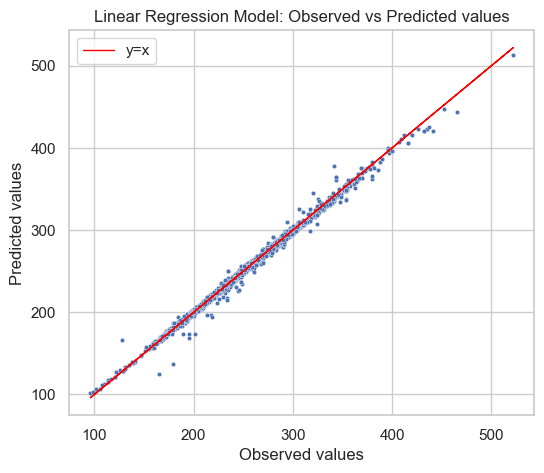

In [ ]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
lr_test_pred = lr_model.predict(X_test)

lr_test_r2 = r2_score(lr_test_pred, y_test)
lr_test_mse = mean_squared_error(lr_test_pred, y_test)
lr_test_mae = mean_absolute_error(lr_test_pred, y_test)
lr_test_mape = mean_absolute_percentage_error(lr_test_pred, y_test)

# Output
print(f'Linear Regression Model:')
print(f"    Test Dataset MSE: {lr_test_mse:.4f}")
print(f"    Test Dataset R2: {lr_test_r2:.4f}")
print(f"    Test Dataset MAE: {lr_test_mae:.4f}")
print(f"    Test Dataset MAPE: {lr_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, lr_test_pred, ax)
plt.title('Linear Regression Model: Observed vs Predicted values')

In [388]:
print(f"Test Dataset MSE: {lr_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(lr_k_fold_mse):.4f}")

Test Dataset MSE: 21.5307
Validation Dataset MSE: 28.1498


### 1.2 Neural Network Model

From the previous coursework, identify the best Neural Network is `MultiLayerPercepton`. And from the results from WandB, the best hyperparameters are as follows:

- **hidden layer**: 4

- **hidden size**: 128

- **learning rate**: 0.001

So in this coursework, for Neural Network Model, `MutliLayerPercepton` is selected as the optimal model.

In [389]:
class NN_MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super(NN_MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
from torch.utils.data import Subset
from torch import optim

# Training Hyperparameters-------------------
num_epochs = 100
batch_size = 64

# Model Hyperparameters ----------------
input_dim = X_train.shape[1]  # input dimension
hidden_layer = 4
hidden_size = 128
learning_rate = 0.001

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = NN_MultiLayerPerceptron(input_dim, hidden_size, hidden_layer).to(device)
    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    # concatenate the true and predicted values
    # nn_all_y_true.append(np.concatenate(y_true_fold, axis=0))
    # nn_all_y_pred.append(np.concatenate(y_pred_fold, axis=0))
    
    # avg_val_loss = val_loss / len(val_loader)
    # nn_k_fold_mse.append(avg_val_loss)

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")

Neural Network Model:

Fold 1 Validation Dataset MSE: 12.0051
Fold 2 Validation Dataset MSE: 14.3170
Fold 3 Validation Dataset MSE: 8.4938
Fold 4 Validation Dataset MSE: 8.1029
Fold 5 Validation Dataset MSE: 9.1560
Fold 6 Validation Dataset MSE: 10.1916
Fold 7 Validation Dataset MSE: 7.5751
Fold 8 Validation Dataset MSE: 6.9793
Fold 9 Validation Dataset MSE: 11.2304
Fold 10 Validation Dataset MSE: 8.2312
Fold 11 Validation Dataset MSE: 6.2675
Fold 12 Validation Dataset MSE: 8.4546
Fold 13 Validation Dataset MSE: 8.9215
Fold 14 Validation Dataset MSE: 9.1330
Fold 15 Validation Dataset MSE: 11.2724
Fold 16 Validation Dataset MSE: 8.7423
Fold 17 Validation Dataset MSE: 9.9125
Fold 18 Validation Dataset MSE: 12.6421
Fold 19 Validation Dataset MSE: 8.9591
Fold 20 Validation Dataset MSE: 15.7812

K-Fold Average MSE: 9.8184

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 17.0788
    Test Dataset R2: 0.9950
    Test Dataset MAE: 3.1664
    Test Dataset MAPE: 0.0132


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

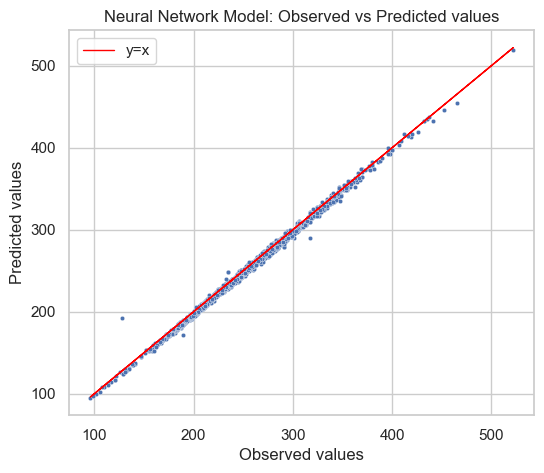

In [ ]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [392]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 17.0788
Validation Dataset MSE: 9.8184


### 1.3 Decision Tree Model

Use decision Tree Model to predict the CO2 emission. 

In [393]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Save MSE and True/Predict Values---------------------------
dt_k_fold_mse = []
dt_k_fold_R2 = []
dt_k_fold_mae = []
dt_k_fold_mape = []

# Train and Evaluate the model----------------------------
print(f'Decision Tree Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):
    
    X_train_fold, X_val_fold = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and train the model
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = dt_model.predict(X_val_fold)

    mse = mean_squared_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    dt_k_fold_mse.append(mse)
    dt_k_fold_R2.append(r2)
    dt_k_fold_mae.append(mae)
    dt_k_fold_mape.append(mape)

    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(dt_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Decision Tree Model:

Fold 1 Validation Dataset MSE: 9.3319
Fold 2 Validation Dataset MSE: 8.5932
Fold 3 Validation Dataset MSE: 8.4441
Fold 4 Validation Dataset MSE: 8.8572
Fold 5 Validation Dataset MSE: 6.9552
Fold 6 Validation Dataset MSE: 11.3388
Fold 7 Validation Dataset MSE: 7.8194
Fold 8 Validation Dataset MSE: 8.0127
Fold 9 Validation Dataset MSE: 8.8874
Fold 10 Validation Dataset MSE: 30.2845
Fold 11 Validation Dataset MSE: 6.2967
Fold 12 Validation Dataset MSE: 7.3840
Fold 13 Validation Dataset MSE: 6.7587
Fold 14 Validation Dataset MSE: 7.4935
Fold 15 Validation Dataset MSE: 9.2731
Fold 16 Validation Dataset MSE: 9.4797
Fold 17 Validation Dataset MSE: 8.6833
Fold 18 Validation Dataset MSE: 6.1342
Fold 19 Validation Dataset MSE: 8.4474
Fold 20 Validation Dataset MSE: 10.2950

K-Fold Average MSE: 9.4385

--------Finished training and validating the model!--------


Decision Tree Model:
    Test Dataset MSE: 12.6142
    Test Dataset R2: 0.9963
    Test Dataset MAE: 1.6717
    Test Dataset MAPE: 0.0069


Text(0.5, 1.0, 'Decision Tree Model: Observed vs Predicted values')

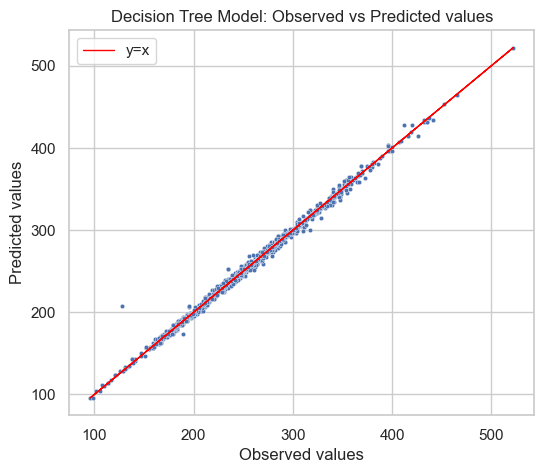

In [394]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
dt_test_pred = dt_model.predict(X_test_df)

dt_test_r2 = r2_score(dt_test_pred, y_test)
dt_test_mse = mean_squared_error(dt_test_pred, y_test)
dt_test_mae = mean_absolute_error(dt_test_pred, y_test)
dt_test_mape = mean_absolute_percentage_error(dt_test_pred, y_test)

# Output
print(f'Decision Tree Model:')
print(f"    Test Dataset MSE: {dt_test_mse:.4f}")
print(f"    Test Dataset R2: {dt_test_r2:.4f}")
print(f"    Test Dataset MAE: {dt_test_mae:.4f}")
print(f"    Test Dataset MAPE: {dt_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, dt_test_pred, ax)
plt.title('Decision Tree Model: Observed vs Predicted values')

In [395]:
# Inspect some values
# print(f"{dt_k_fold_mse}")
# print(f"{dt_test_mse}")

print(f"Test Dataset MSE: {dt_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(dt_k_fold_mse):.4f}")

print(f"Test Dataset R2: {dt_test_r2:.4f}")
print(f"Validation Dataset R2: {np.mean(dt_k_fold_R2):.4f}")

print(f"Test Dataset MAE: {dt_test_mae:.4f}")
print(f"Validation Dataset MAE: {np.mean(dt_k_fold_mae):.4f}")

print(f"Test Dataset MAPE: {dt_test_mape:.4f}")
print(f"Validation Dataset MAPRE: {np.mean(dt_k_fold_mape):.4f}")

Test Dataset MSE: 12.6142
Validation Dataset MSE: 9.4385
Test Dataset R2: 0.9963
Validation Dataset R2: 0.9972
Test Dataset MAE: 1.6717
Validation Dataset MAE: 1.6526
Test Dataset MAPE: 0.0069
Validation Dataset MAPRE: 0.0067


### 1.4 PCA Based Regression Model

From previous coursework, I analysed the Regression model based on selected PCA conponents, and find the best model is to use all the PCA conponents. 
But in the previous coursework, the categorical variables are not encoded and included in the PCA analysis. So PCA conponent based regression model should be finetuned to select the optimal model.

In [396]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

pca = PCA() # n_components=0.95
scaler_pca = StandardScaler()

# Save MSE and True/Predict Values---------------------------
pca_k_fold_mse = []
pca_k_fold_R2 = []
pca_k_fold_mae = []
pca_k_fold_mape = []

# Train and Evaluate the model----------------------------
print(f'PCA Based Regression Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    X_train_fold, X_val_fold = X_train_df.iloc[train_index], X_train_df.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Perform PCA on the training dataset
    X_train_pca = pca.fit_transform(X_train_fold)
    X_val_pca = pca.transform(X_val_fold)

    # Select all the conponents (exclue the last two components)
    X_train_pca_select = X_train_pca[:, :-2]
    X_val_pca_select = X_val_pca[:, :-2]

    # X_train_pca_select = X_train_pca
    # X_val_pca_select = X_val_pca

    # Fit the linear regression model
    pca_lr_model = LinearRegression()
    pca_lr_model.fit(X_train_pca_select, y_train_fold)

    y_pred_fold = pca_lr_model.predict(X_val_pca_select)
    
    # Calculate the mean squared error (MSE)
    mse = mean_squared_error(y_val_fold, y_pred_fold)
    r2 = r2_score(y_val_fold, y_pred_fold)
    mae = mean_absolute_error(y_val_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_val_fold, y_pred_fold)

    pca_k_fold_mse.append(mse)
    pca_k_fold_R2.append(r2)
    pca_k_fold_mae.append(mae)
    pca_k_fold_mape.append(mape)

    print(f"Fold {fold + 1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(pca_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


PCA Based Regression Model:

Fold 1 Validation Dataset MSE: 17.5194
Fold 2 Validation Dataset MSE: 31.8510
Fold 3 Validation Dataset MSE: 19.1056
Fold 4 Validation Dataset MSE: 20.7628
Fold 5 Validation Dataset MSE: 22.4198
Fold 6 Validation Dataset MSE: 46.1904
Fold 7 Validation Dataset MSE: 38.3613
Fold 8 Validation Dataset MSE: 23.2841
Fold 9 Validation Dataset MSE: 37.6981
Fold 10 Validation Dataset MSE: 57.4788
Fold 11 Validation Dataset MSE: 26.2257
Fold 12 Validation Dataset MSE: 16.7673
Fold 13 Validation Dataset MSE: 15.5130
Fold 14 Validation Dataset MSE: 17.6877
Fold 15 Validation Dataset MSE: 26.3558
Fold 16 Validation Dataset MSE: 31.4551
Fold 17 Validation Dataset MSE: 28.6512
Fold 18 Validation Dataset MSE: 30.6938
Fold 19 Validation Dataset MSE: 16.4837
Fold 20 Validation Dataset MSE: 38.4916

K-Fold Average MSE: 28.1498

--------Finished training and validating the model!--------


Decision Tree Model:
    Test Dataset MSE: 21.5307
    Test Dataset R2: 0.9935
    Test Dataset MAE: 2.8791
    Test Dataset MAPE: 0.0117


Text(0.5, 1.0, 'PCA Based Regression Model: Observed vs Predicted values')

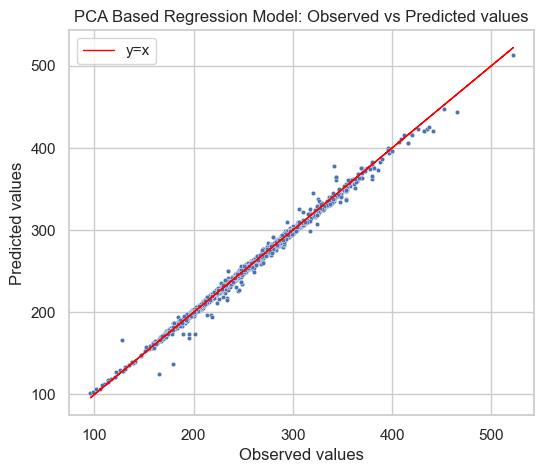

In [397]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE

# X_test_pca = pca.transform(X_test_df)
X_test_pca = pca.transform(X_test_df)[:, :-2]

pca_test_pred = pca_lr_model.predict(X_test_pca)

pca_test_r2 = r2_score(pca_test_pred, y_test)
pca_test_mse = mean_squared_error(pca_test_pred, y_test)
pca_test_mae = mean_absolute_error(pca_test_pred, y_test)
pca_test_mape = mean_absolute_percentage_error(pca_test_pred, y_test)

# Output
print(f'Decision Tree Model:')
print(f"    Test Dataset MSE: {pca_test_mse:.4f}")
print(f"    Test Dataset R2: {pca_test_r2:.4f}")
print(f"    Test Dataset MAE: {pca_test_mae:.4f}")
print(f"    Test Dataset MAPE: {pca_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, pca_test_pred, ax)
plt.title('PCA Based Regression Model: Observed vs Predicted values')

In [398]:
# Inspect some values
print(f"{pca_k_fold_mse}")
print(f"{pca_test_mse}")
print(f"PCA component shape: {X_train_pca_select.shape}")

print(f"Test Dataset MSE: {pca_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(pca_k_fold_mse):.4f}")

[17.519404585720967, 31.85099397892638, 19.105647748779393, 20.762829508359225, 22.419833763075776, 46.190350214729165, 38.361336550387456, 23.28412406893701, 37.698064081775556, 57.47884179867971, 26.22570258385282, 16.767326225405988, 15.512997830883364, 17.687679807202002, 26.355767466261625, 31.455137030235655, 28.65116475384985, 30.693846969149973, 16.4836977014868, 38.49162483832732]
21.53070569791022
PCA component shape: (5613, 51)
Test Dataset MSE: 21.5307
Validation Dataset MSE: 28.1498


## 2 Performance Comparison of Different Models

Collect the performance scores of different models.

In [399]:
# Model dictionary
models = {
    "Linear Regression": lr_model,
    "Neural Network": nn_model,
    "Decision Tree": dt_model,
    "PCA Regression": pca_lr_model
}

# Model Validation Scores
# MSE
models_val_mse = np.array([lr_k_fold_mse, nn_k_fold_mse, dt_k_fold_mse, pca_k_fold_mse])
print(models_val_mse)

# R2
models_val_r2 = np.array([lr_k_fold_R2, nn_k_fold_R2, dt_k_fold_R2, pca_k_fold_R2])
print(models_val_r2)

# MAE
models_val_mae = np.array([lr_k_fold_mae, nn_k_fold_mae, dt_k_fold_mae, pca_k_fold_mae])
print(models_val_mae)

# MAPE
models_val_mape = np.array([lr_k_fold_mape, nn_k_fold_mape, dt_k_fold_mape, pca_k_fold_mape])
print(models_val_mape)

# Model Test Scores
# MSE
models_test_mse = np.array([lr_test_mse, nn_test_mse, dt_test_mse, pca_test_mse])
print(models_test_mse)

# R2
models_test_r2 = np.array([lr_test_r2, nn_test_r2, dt_test_r2, pca_test_r2])
print(models_test_r2)

# MAE
models_test_mae = np.array([lr_test_mae, nn_test_mae, dt_test_mae, pca_test_mae])
print(models_test_mae)

# MAPE
models_test_mape = np.array([lr_test_mape, nn_test_mape, dt_test_mape, pca_test_mape])
print(models_test_mae)

[[17.51940459 31.85099398 19.10564775 20.76282951 22.41983376 46.19035021
  38.36133655 23.28412407 37.69806408 57.4788418  26.22570258 16.76732623
  15.51299783 17.68767981 26.35576747 31.45513703 28.65116475 30.69384697
  16.4836977  38.49162484]
 [12.00514698 14.3170433   8.49375629  8.10290051  9.15598774 10.19160461
   7.57511425  6.97928333 11.23040199  8.23117924  6.26754856  8.45463181
   8.92147636  9.13297939 11.27238274  8.74226665  9.91250801 12.64214897
   8.95907402 15.78116035]
 [ 9.33188939  8.5932423   8.44406845  8.85715646  6.95517551 11.33880795
   7.81944623  8.01270364  8.887396   30.28447863  6.29670681  7.38399733
   6.75869225  7.49351761  9.27312458  9.47972267  8.68331294  6.1341792
   8.44743787 10.29498268]
 [17.51940459 31.85099398 19.10564775 20.76282951 22.41983376 46.19035021
  38.36133655 23.28412407 37.69806408 57.4788418  26.22570258 16.76732623
  15.51299783 17.68767981 26.35576747 31.45513703 28.65116475 30.69384697
  16.4836977  38.49162484]]
[[0.

### 2.1 Normality Check

For normality check, **Shapiro-Wilk Test** is used.

Define funtion to check the metric normality:

- Input: 

    - models: containing model information (name, index), *dictionary*

    - model_val_scores: the performance metric on k-fold validation, *np.array*

- Output: 

    - `result_table`, all results of different models, including `Model`[character], `Shapiro-Wilk Test Statistic`[number], `p-value`[number], `Normality`[character], *DataFrame*
    - `if_normal_arrary`, an arrary indicator to show if the meteric is normal distributed. 
    


In [400]:
from scipy.stats import shapiro
alpha = 0.1

In [401]:
def check_normality(models, model_val_scores):

    result_table = []           # table - all information
    if_normal_arrary = []       # 1D arrary, indicate Yes or No

    # Iterate every model
    for i, model_name in enumerate(models.keys()):
        stat, p_value = shapiro(model_val_scores[i])

        print(f"{model_name}: Statistic={stat:.4f}, p-value={p_value:.4f}")
        normality = "❌ No" if p_value < alpha else "✅ Yes"

        if p_value > alpha:
            print(f"    ✅ {model_name} performance scores appear to be normally distributed.")
            if_normal_arrary.append("Yes")
        else:
            print(f"    ❌ {model_name} performance scores are NOT normally distributed.")
            if_normal_arrary.append("No")

        result_table.append([model_name, stat, p_value, normality])

    return pd.DataFrame(result_table, columns=["Model", "Shapiro-Wilk Test Statistic", "p-value", "Normality"]), if_normal_arrary

In [402]:
# Check MSE
print("\n-------Shapiro-Wilk Test: Normality Check MSE------------------------------\n")
df_result_normality_MSE, normality_MSE = check_normality(models, models_val_mse)



-------Shapiro-Wilk Test: Normality Check MSE------------------------------

Linear Regression: Statistic=0.9056, p-value=0.0527
    ❌ Linear Regression performance scores are NOT normally distributed.
Neural Network: Statistic=0.9219, p-value=0.1076
    ✅ Neural Network performance scores appear to be normally distributed.
Decision Tree: Statistic=0.4738, p-value=0.0000
    ❌ Decision Tree performance scores are NOT normally distributed.
PCA Regression: Statistic=0.9056, p-value=0.0527
    ❌ PCA Regression performance scores are NOT normally distributed.


In [403]:
# Check R2
print("\n-------Shapiro-Wilk Test: Normality Check R2------------------------------\n")
df_result_normality_R2, normality_R2 = check_normality(models, models_val_r2)



-------Shapiro-Wilk Test: Normality Check R2------------------------------

Linear Regression: Statistic=0.8826, p-value=0.0197
    ❌ Linear Regression performance scores are NOT normally distributed.
Neural Network: Statistic=0.9090, p-value=0.0609
    ❌ Neural Network performance scores are NOT normally distributed.
Decision Tree: Statistic=0.4802, p-value=0.0000
    ❌ Decision Tree performance scores are NOT normally distributed.
PCA Regression: Statistic=0.8826, p-value=0.0197
    ❌ PCA Regression performance scores are NOT normally distributed.


In [404]:
# Check MAE
print("\n-------Shapiro-Wilk Test: Normality Check MAE------------------------------\n")
df_result_normality_MAE, normality_MAE = check_normality(models, models_val_mae)



-------Shapiro-Wilk Test: Normality Check MAE------------------------------

Linear Regression: Statistic=0.9374, p-value=0.2141
    ✅ Linear Regression performance scores appear to be normally distributed.
Neural Network: Statistic=0.9128, p-value=0.0719
    ❌ Neural Network performance scores are NOT normally distributed.
Decision Tree: Statistic=0.9246, p-value=0.1217
    ✅ Decision Tree performance scores appear to be normally distributed.
PCA Regression: Statistic=0.9374, p-value=0.2141
    ✅ PCA Regression performance scores appear to be normally distributed.


In [405]:
# Check MAPE
print("\n-------Shapiro-Wilk Test: Normality Check MAPE------------------------------")
df_result_normality_MAPE, normality_MAPE = check_normality(models, models_val_mape)


-------Shapiro-Wilk Test: Normality Check MAPE------------------------------
Linear Regression: Statistic=0.9331, p-value=0.1771
    ✅ Linear Regression performance scores appear to be normally distributed.
Neural Network: Statistic=0.8953, p-value=0.0337
    ❌ Neural Network performance scores are NOT normally distributed.
Decision Tree: Statistic=0.9051, p-value=0.0515
    ❌ Decision Tree performance scores are NOT normally distributed.
PCA Regression: Statistic=0.9331, p-value=0.1771
    ✅ PCA Regression performance scores appear to be normally distributed.


Judging from the Shapiro-Wilk Test, **the performance metrics (MSE and R2) of all the four models are not normally distributed**. Thus nomrality assumption does not hold. For the following overfitting check and comparison check, tests under assumption that normality does not hold are selected. But for MAE metric, normality holds.

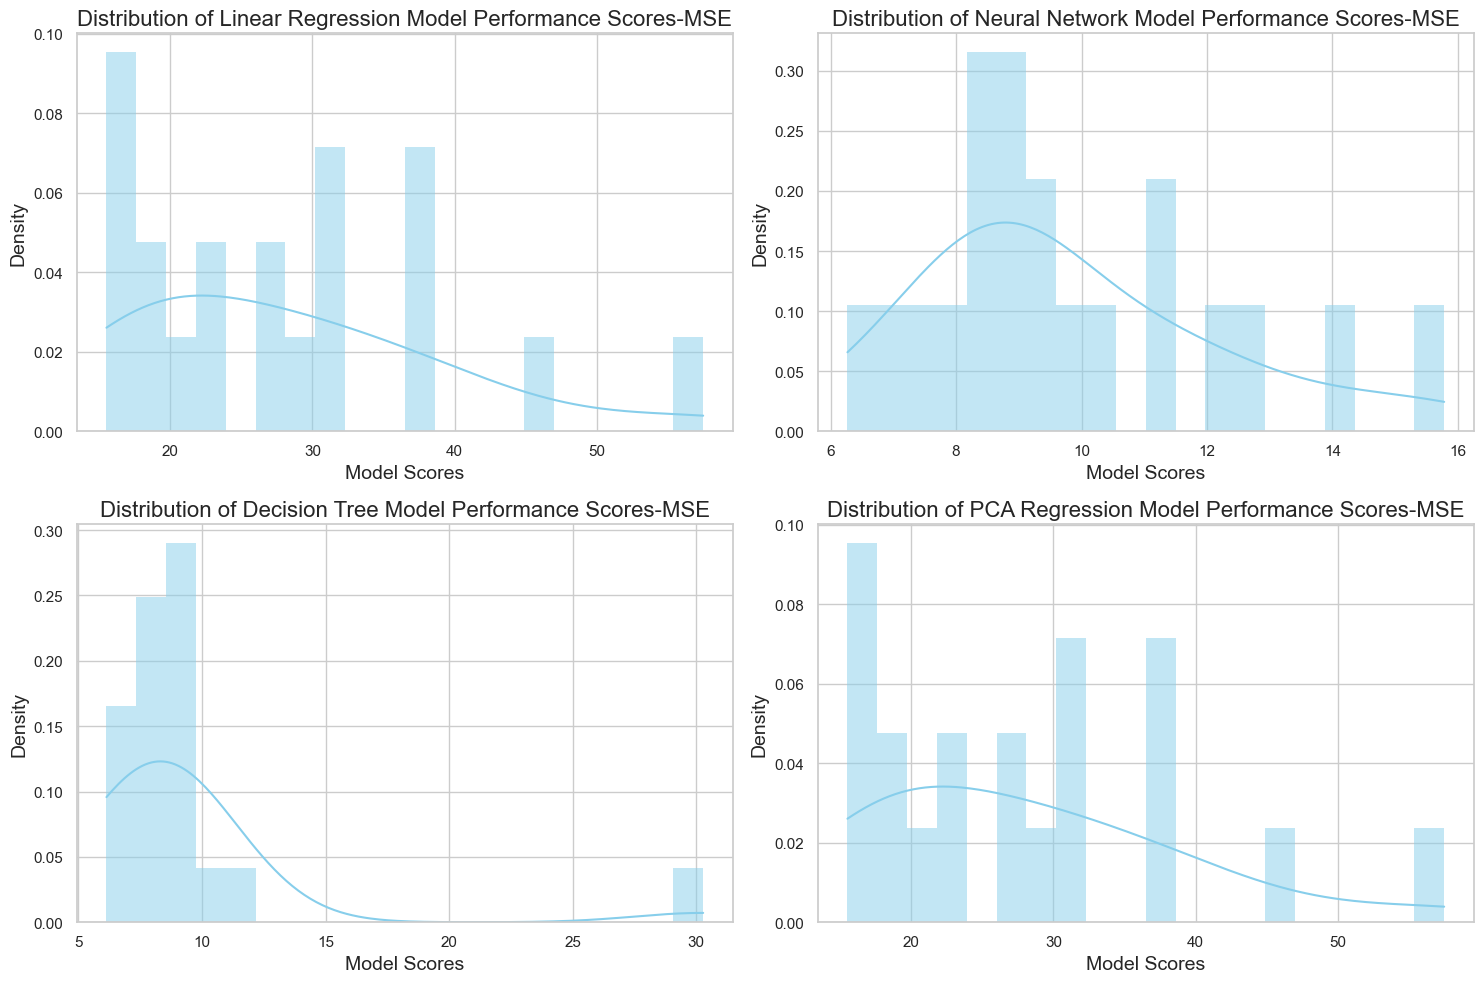

In [406]:
# Check normality by ploting
import seaborn as sns

# Check nomality of Four models
fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = ax.flatten()

for i, model_name in enumerate(models.keys()):
    sns.set_theme(style="whitegrid")
    sns.histplot(models_val_mse[i], kde=True, bins=20, color="skyblue", stat="density", linewidth=0, ax=ax[i])
    ax[i].set_title(f"Distribution of {model_name} Model Performance Scores-MSE", fontsize=16)
    ax[i].set_xlabel("Model Scores", fontsize=14)
    ax[i].set_ylabel("Density", fontsize=14)

plt.tight_layout()
plt.show()

- Since the normality does not hold for all the models, **One-sample Wilcoxon Test** should be used to check overfittting. And for model comparison and selection,  Friedman Test and successive Nemenyi test should be employed.

### 2.2 Overfitting Check

For overfitting check, since the normality varies, **One-Sample Wilcoxon Test**  or **One-Sample t-test** is chosen based on the normality of the metric.

Define funtion to check the risk of overfitting:

- Input: 

    - models: containing model information (name, index), dictionary

    - model_val_scores: the performance metric on k-fold validation, np.array
    
    - model_test_scores: the performance metric on k-fold validation, np.array
    
    - normality - containing metric normality, np.array

    - h1 - alternative type: H1 hypothesis, indicating whether "less" shows sign of overfitting or "greater" shows sign of overfitting

- Output: 

    - all results of different models, including `Model`[character], `If Normal`[character], `Test Type`[character], `Test statistic`[number], `p-value`[number], `Overfitting`[character]


In [407]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
alpha = 0.1


In [408]:
# Define function to check overfitting
def check_overfitting(models, model_val_scores, model_test_scores, normality, h1):

    save_result = []

    # Iterate every model
    for i, model_name in enumerate(models.keys()):

        train_scores = model_val_scores[i]
        test_scores = model_test_scores[i]

        # Select test based on the normality check results
        if normality[i] == "Yes":  # Use One-sample t-test
            test_type = "One-sample t-test"
            stat, p_value = ttest_1samp(train_scores, test_scores) 


        if normality[i] == "No":  # Use One-sample Wilcoxon-test
            test_type = "One-sample Wilcoxon-test"
            difference = train_scores - test_scores
            stat, p_value = wilcoxon(difference, alternative=h1)  

        # summary overfitting results
        overfitting = "⚠️ Potenial overfitting" if p_value < alpha else "✅ NO Risk of overfitting"

        print(f"    {model_name}:  Test-statistic={stat:.4f}, p-value={p_value:.4f}")

        if p_value < alpha:
            print(f"⚠️ For {model_name}, {test_type} shows significant difference: Potenial overfitting!")
        else:
            print(f"✅ For {model_name}, {test_type} shows NO significant difference: NO Risk of overfitting.")
        
        save_result.append([model_name, normality[i], test_type, stat, p_value, overfitting])

    return pd.DataFrame(save_result, columns=["Model", "If Normal", "Test Type", "Test statistic", "p-value", "Overfitting"])

#### MSE as metric

In [409]:
# Check Overfitting using MSE
# Overfitting sign: MSE for train is significantly smaller than in test, alternative is gap less than 0, h1=less
print("\n-------Overfitting Check MSE------------------")
df_result_overfitting_MSE = check_overfitting(models, models_val_mse, models_test_mse, normality_MSE, h1="less")



-------Overfitting Check MSE------------------
    Linear Regression:  Test-statistic=165.0000, p-value=0.9893
✅ For Linear Regression, One-sample Wilcoxon-test shows NO significant difference: NO Risk of overfitting.
    Neural Network:  Test-statistic=-13.4218, p-value=0.0000
⚠️ For Neural Network, One-sample t-test shows significant difference: Potenial overfitting!
    Decision Tree:  Test-statistic=20.0000, p-value=0.0004
⚠️ For Decision Tree, One-sample Wilcoxon-test shows significant difference: Potenial overfitting!
    PCA Regression:  Test-statistic=165.0000, p-value=0.9893
✅ For PCA Regression, One-sample Wilcoxon-test shows NO significant difference: NO Risk of overfitting.


In [410]:
normality_MSE

['No', 'Yes', 'No', 'No']

#### R2 as metric

In [411]:
# Check Overfitting using R2
# Overfitting sign: R2 for train is significantly higher than in test, alternative is gap greater than 0, h1=greater
print("\n-------Overfitting Check R2------------------")
df_result_overfitting_R2 = check_overfitting(models, models_val_r2, models_test_r2, normality_R2, h1="greater")


-------Overfitting Check R2------------------
    Linear Regression:  Test-statistic=47.0000, p-value=0.9867
✅ For Linear Regression, One-sample Wilcoxon-test shows NO significant difference: NO Risk of overfitting.
    Neural Network:  Test-statistic=210.0000, p-value=0.0000
⚠️ For Neural Network, One-sample Wilcoxon-test shows significant difference: Potenial overfitting!
    Decision Tree:  Test-statistic=190.0000, p-value=0.0004
⚠️ For Decision Tree, One-sample Wilcoxon-test shows significant difference: Potenial overfitting!
    PCA Regression:  Test-statistic=47.0000, p-value=0.9867
✅ For PCA Regression, One-sample Wilcoxon-test shows NO significant difference: NO Risk of overfitting.


#### MAE as metric

In [412]:
# Check Overfitting using R2
# Overfitting sign: MSE for train is significantly smaller than in test, alternative is gap less than 0, h1=less
print("\n-------Overfitting Check MAE------------------")
df_result_overfitting_MAE = check_overfitting(models, models_val_mae, models_test_mae, normality_MAE, h1="less")


-------Overfitting Check MAE------------------
    Linear Regression:  Test-statistic=1.5583, p-value=0.1357
✅ For Linear Regression, One-sample t-test shows NO significant difference: NO Risk of overfitting.
    Neural Network:  Test-statistic=0.0000, p-value=0.0000
⚠️ For Neural Network, One-sample Wilcoxon-test shows significant difference: Potenial overfitting!
    Decision Tree:  Test-statistic=-0.5930, p-value=0.5602
✅ For Decision Tree, One-sample t-test shows NO significant difference: NO Risk of overfitting.
    PCA Regression:  Test-statistic=1.5583, p-value=0.1357
✅ For PCA Regression, One-sample t-test shows NO significant difference: NO Risk of overfitting.


#### MAPE as metric

In [413]:
# Check Overfitting using R2
# Overfitting sign: MSE for train is significantly smaller than in test, alternative is gap less than 0, h1=less
print("\n-------Overfitting Check MAE------------------")
df_result_overfitting_MAPE = check_overfitting(models, models_val_mape, models_test_mape, normality_MAPE, h1="less")


-------Overfitting Check MAE------------------
    Linear Regression:  Test-statistic=0.2362, p-value=0.8158
✅ For Linear Regression, One-sample t-test shows NO significant difference: NO Risk of overfitting.
    Neural Network:  Test-statistic=0.0000, p-value=0.0000
⚠️ For Neural Network, One-sample Wilcoxon-test shows significant difference: Potenial overfitting!
    Decision Tree:  Test-statistic=64.0000, p-value=0.0664
⚠️ For Decision Tree, One-sample Wilcoxon-test shows significant difference: Potenial overfitting!
    PCA Regression:  Test-statistic=0.2362, p-value=0.8158
✅ For PCA Regression, One-sample t-test shows NO significant difference: NO Risk of overfitting.


- From the checking results above, using metric like MSE or R-square show that Decision tree and Neural Network model has potenial risk of overfitting, while PCA and Linear Regression passed the overfitting check.

- But if using the MAPE as metric, test results show that all model pass the overfitting check, showing no risk of overfitting. 

- In conclusion, considering the comprehensive performances of different metrics, **all the models are feasible** and can be further checked to determine the optimal model.

### 2.3 Compare the Performance of Different Models

#### 2.3.1 Friedman Test to check if significant different exists between models

In [414]:
from scipy.stats import ttest_rel, friedmanchisquare

# Perform ANOVA test
friedman_stat, friedman_p = friedmanchisquare(*models_val_r2)

print(f"Friedman Test: F-statistic={friedman_stat:.4f}, p-value={friedman_p:.4f}")

# Interpret the results
alpha = 0.05
if friedman_p < alpha:
    print("❌ Friedman Test: Reject the null hypothesis: At least one model is significantly different.")
else:
    print("✅ Friedman Test: Fail to reject the null hypothesis: All models are not significantly different.")



Friedman Test: F-statistic=52.4919, p-value=0.0000
❌ Friedman Test: Reject the null hypothesis: At least one model is significantly different.


- So there exists at least one model that performs better than the rest.

#### 2.3.2 Nemenyi Test to Select the Best Model

- In the model selection part, MSE is used as performance metric to select the optimal model.

Post-hoc Nemenyi test results:
          0         1             2             3
0  1.000000  0.000081  2.221835e-06  9.830590e-01
1  0.000081  1.000000  8.830866e-01  1.434714e-05
2  0.000002  0.883087  1.000000e+00  3.012909e-07
3  0.983059  0.000014  3.012909e-07  1.000000e+00


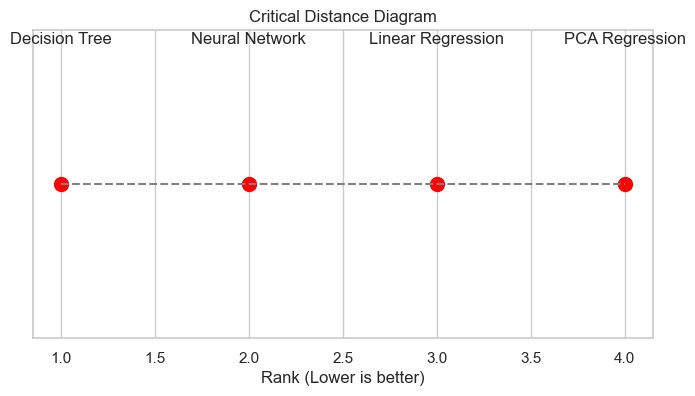

In [415]:
import scikit_posthocs as sp

# Post-hoc Nemenyi test if Friedman test is significant
if friedman_p < 0.05:
    posthoc_results = sp.posthoc_nemenyi_friedman(models_val_mse.T)
    print("Post-hoc Nemenyi test results:")
    print(posthoc_results)

    # Plot Critical Distance (CD) Diagram
    ranks = np.argsort(models_val_mse.mean(axis=1)) + 1  # Ranking models
    model_names = list(models.keys())

    plt.figure(figsize=(8, 4))
    plt.scatter(ranks, [1] * len(model_names), marker='o', color='red', s=100, label='Models')
    plt.hlines(y=1, xmin=min(ranks), xmax=max(ranks), colors='gray', linestyles='dashed')

    for rank, name in zip(ranks, model_names):
        plt.text(rank, 1.05, name, ha='center', fontsize=12)

    plt.title("Critical Distance Diagram")
    plt.xlabel("Rank (Lower is better)")
    plt.yticks([])  # Hide y-axis labels
    plt.show()

## 3 Produce multiple tables 

### 3.1 Normality and Overfitting Check

#### Normality Check Results

- MSE

In [416]:
# Shapiro-Wilk test
print("\nNormality Test Results for MSE:\n")
print(df_result_normality_MSE.to_markdown(index=False))


Normality Test Results for MSE:

| Model             |   Shapiro-Wilk Test Statistic |     p-value | Normality   |
|:------------------|------------------------------:|------------:|:------------|
| Linear Regression |                      0.905641 | 0.0526738   | ❌ No       |
| Neural Network    |                      0.921856 | 0.107583    | ✅ Yes      |
| Decision Tree     |                      0.473804 | 1.85812e-07 | ❌ No       |
| PCA Regression    |                      0.905641 | 0.0526738   | ❌ No       |


- R2

In [417]:
print("\nNormality Test Results for R2:\n")
print(df_result_normality_R2.to_markdown(index=False))


Normality Test Results for R2:

| Model             |   Shapiro-Wilk Test Statistic |     p-value | Normality   |
|:------------------|------------------------------:|------------:|:------------|
| Linear Regression |                      0.882609 | 0.0197169   | ❌ No       |
| Neural Network    |                      0.908972 | 0.0609264   | ❌ No       |
| Decision Tree     |                      0.480217 | 2.11582e-07 | ❌ No       |
| PCA Regression    |                      0.882609 | 0.0197169   | ❌ No       |


- MAE

In [418]:
print("\nNormality Test Results for MAE:\n")
print(df_result_normality_MAE.to_markdown(index=False))


Normality Test Results for MAE:

| Model             |   Shapiro-Wilk Test Statistic |   p-value | Normality   |
|:------------------|------------------------------:|----------:|:------------|
| Linear Regression |                      0.937408 | 0.214109  | ✅ Yes      |
| Neural Network    |                      0.912753 | 0.0719345 | ❌ No       |
| Decision Tree     |                      0.924637 | 0.121714  | ✅ Yes      |
| PCA Regression    |                      0.937408 | 0.214109  | ✅ Yes      |


- MAPE

In [419]:
print("\nNormality Test Results for MAPE:\n")
print(df_result_normality_MAPE.to_markdown(index=False))


Normality Test Results for MAPE:

| Model             |   Shapiro-Wilk Test Statistic |   p-value | Normality   |
|:------------------|------------------------------:|----------:|:------------|
| Linear Regression |                      0.933099 | 0.177119  | ✅ Yes      |
| Neural Network    |                      0.895281 | 0.0336691 | ❌ No       |
| Decision Tree     |                      0.905133 | 0.0515195 | ❌ No       |
| PCA Regression    |                      0.933099 | 0.177119  | ✅ Yes      |


#### Overfitting Check

- MSE

In [420]:
print("\nONe-sample Wilcoxon Test Results for MSE:\n")
print(df_result_overfitting_MSE.to_markdown(index=False))


ONe-sample Wilcoxon Test Results for MSE:

| Model             | If Normal   | Test Type                |   Test statistic |     p-value | Overfitting               |
|:------------------|:------------|:-------------------------|-----------------:|------------:|:--------------------------|
| Linear Regression | No          | One-sample Wilcoxon-test |         165      | 0.989258    | ✅ NO Risk of overfitting |
| Neural Network    | Yes         | One-sample t-test        |         -13.4218 | 3.82388e-11 | ⚠️ Potenial overfitting   |
| Decision Tree     | No          | One-sample Wilcoxon-test |          20      | 0.000353813 | ⚠️ Potenial overfitting   |
| PCA Regression    | No          | One-sample Wilcoxon-test |         165      | 0.989258    | ✅ NO Risk of overfitting |


- R2

In [421]:
print("\nONe-sample Wilcoxon Test Results for R2:")
print(df_result_overfitting_R2.to_markdown(index=False))


ONe-sample Wilcoxon Test Results for R2:
| Model             | If Normal   | Test Type                |   Test statistic |     p-value | Overfitting               |
|:------------------|:------------|:-------------------------|-----------------:|------------:|:--------------------------|
| Linear Regression | No          | One-sample Wilcoxon-test |               47 | 0.986679    | ✅ NO Risk of overfitting |
| Neural Network    | No          | One-sample Wilcoxon-test |              210 | 9.53674e-07 | ⚠️ Potenial overfitting   |
| Decision Tree     | No          | One-sample Wilcoxon-test |              190 | 0.000353813 | ⚠️ Potenial overfitting   |
| PCA Regression    | No          | One-sample Wilcoxon-test |               47 | 0.986679    | ✅ NO Risk of overfitting |


- MAE

In [422]:
print("\nOne-sample t-Test Results for MAE:")
print(df_result_overfitting_MAE.to_markdown(index=False))


One-sample t-Test Results for MAE:
| Model             | If Normal   | Test Type                |   Test statistic |     p-value | Overfitting               |
|:------------------|:------------|:-------------------------|-----------------:|------------:|:--------------------------|
| Linear Regression | Yes         | One-sample t-test        |         1.55826  | 0.135673    | ✅ NO Risk of overfitting |
| Neural Network    | No          | One-sample Wilcoxon-test |         0        | 9.53674e-07 | ⚠️ Potenial overfitting   |
| Decision Tree     | Yes         | One-sample t-test        |        -0.593031 | 0.560154    | ✅ NO Risk of overfitting |
| PCA Regression    | Yes         | One-sample t-test        |         1.55826  | 0.135673    | ✅ NO Risk of overfitting |


- MAPE

In [423]:
print("\nCombined One-sample t-Test/Wilcoxon Test Results for MAPE:")
print(df_result_overfitting_MAPE.to_markdown(index=False))


Combined One-sample t-Test/Wilcoxon Test Results for MAPE:
| Model             | If Normal   | Test Type                |   Test statistic |     p-value | Overfitting               |
|:------------------|:------------|:-------------------------|-----------------:|------------:|:--------------------------|
| Linear Regression | Yes         | One-sample t-test        |         0.236224 | 0.815787    | ✅ NO Risk of overfitting |
| Neural Network    | No          | One-sample Wilcoxon-test |         0        | 9.53674e-07 | ⚠️ Potenial overfitting   |
| Decision Tree     | No          | One-sample Wilcoxon-test |        64        | 0.0663633   | ⚠️ Potenial overfitting   |
| PCA Regression    | Yes         | One-sample t-test        |         0.236224 | 0.815787    | ✅ NO Risk of overfitting |


### 3.2 Model Comparison and Optimal Model Selection

- Nemenyi post-hoc test

In [424]:
posthoc_results = sp.posthoc_nemenyi_friedman(models_val_mse.T)
print("\nPost-hoc Nemenyi test results (p-values):")

print(posthoc_results.to_markdown())



Post-hoc Nemenyi test results (p-values):
|    |           0 |           1 |           2 |           3 |
|---:|------------:|------------:|------------:|------------:|
|  0 | 1           | 8.10546e-05 | 2.22184e-06 | 0.983059    |
|  1 | 8.10546e-05 | 1           | 0.883087    | 1.43471e-05 |
|  2 | 2.22184e-06 | 0.883087    | 1           | 3.01291e-07 |
|  3 | 0.983059    | 1.43471e-05 | 3.01291e-07 | 1           |


### 3.3 Optimal Model and Reflections

- According to the figures and above, it can be shown that **the best model is Decision Tree Model**. Followed by Neural Network model. And the Linear Regression and PCA Regression models are inferior models.

- Considering the overfitting issue with Neural Network Model, **the Decision Tree Model is selected as the optimal model for the CO2 Emission prediction task.**

- In the following code, inspect some feature of the Optimal Model.

In [425]:
# Showing the performance of the optimal model
print(f"Optimal Model: Decision Tree Model")
print(f"    K-fold Validation MSE:  {dt_k_fold_mse}")
print(f"    Mean Validation MSE:    {np.mean(dt_k_fold_mse):3f}")
print(f"    Test Dataset MSE:       {dt_test_mse:3f}")
print(f"    Test Dataset R2:        {dt_test_r2:3f}")
print(f"    Test Dataset MAE:       {dt_test_mae:3f}")
print(f"    Test Dataset MAPE:      {dt_test_mape:3f}")

Optimal Model: Decision Tree Model
    K-fold Validation MSE:  [9.331889387793405, 8.593242304804802, 8.444068451955356, 8.857156460376888, 6.955175507139794, 11.338807949105568, 7.819446230350244, 8.012703641141142, 8.88739600388178, 30.284478631000425, 6.2967068061373945, 7.383997328875052, 6.758692246264482, 7.4935176078592125, 9.273124584171393, 9.479722669011105, 8.683312943319198, 6.134179195972173, 8.447437874459265, 10.294982675672461]
    Mean Validation MSE:    9.438502
    Test Dataset MSE:       12.614240
    Test Dataset R2:        0.996292
    Test Dataset MAE:       1.671719
    Test Dataset MAPE:      0.006880


Text(0.5, 1.0, 'Decision Tree Model: Observed vs Predicted values')

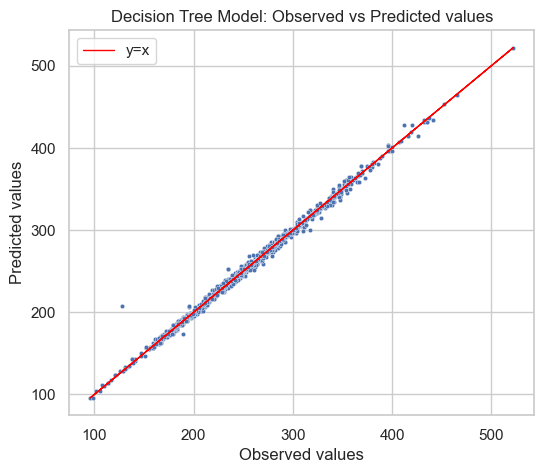

In [426]:
# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(y_test, dt_test_pred, ax)
plt.title('Decision Tree Model: Observed vs Predicted values')

### Reflections and Questions

- Interesting results(?):
    
    - For normality check, **using different performance metric may get different results**, such as for MSE and R2, normality does not hold; but for MAE, normality holds.

- Question: In the normality check, we checked the normality of four models. In the comparison part, normality condition should determine which test should be applied, but what if in the normality check, Model A and B holds normality, but Model C and D do not hold normality? In such case, which test should be used to test performance between A, B, C and D?

- Whether the model has risk of overfitting is to some extent depending on the random seed. If random seed changes, the evaluation may also change.